In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import scipy.stats as sts
import math
%matplotlib inline
import re 
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error
from math import sqrt

In [ ]:
Бизнес-задача. Исследовать данные по зарплатам в Сан- Франциско. Найти факторы, неблагоприятно влияющие на расходование
ФОТ Сан- Франциско.
-сгруппировать данные по департаментам;
-посмотреть, как распределяется бюджет по разным департаментам с течением времени;
-посмотреть, как распределяются базовая оплата, сверхурочная работа и льготы между разными группами;
-посмотреть, какое количество людей в каждом департаменте;
-найти факторы, неблагоприятно влияющие на расход ФОТ;
-на базе линейной регрессии построить прогноз по тому, какие будут зарплаты  в следующий год по каждому департаменту.


In [ ]:
Note: Если в расчетах/комментариях к расчетам стоит *,**...- поясняющий анализ данных/поясняющий расчет/справочная информация 
вынесен в раздел "Cправочно" (вынесен после всех расчетов)

In [10]:
df = pd.read_csv('Salaries1.csv',  sep=',')
df.head()

,Id,EmployeeName,JobTitle,BasePay,OvertimePay,OtherPay,Benefits,TotalPay,TotalPayBenefits,Year,Notes,Agency,Status
0,1,NATHANIEL FORD,GENERAL MANAGER-METROPOLITAN TRANSIT AUTHORITY,167411,0,400184,NaN,567595.43,567595.43,2011,NaN,San Francisco,NaN
1,2,GARY JIMENEZ,CAPTAIN III (POLICE DEPARTMENT),155966,245132,137811,NaN,538909.28,538909.28,2011,NaN,San Francisco,NaN
2,3,ALBERT PARDINI,CAPTAIN III (POLICE DEPARTMENT),212739,106088,16452.6,NaN,335279.91,335279.91,2011,NaN,San Francisco,NaN
3,4,CHRISTOPHER CHONG,WIRE ROPE CABLE MAINTENANCE MECHANIC,77916,56120.7,198307,NaN,332343.61,332343.61,2011,NaN,San Francisco,NaN
4,5,PATRICK GARDNER,"DEPUTY CHIEF OF DEPARTMENT,(FIRE DEPARTMENT)",134402,9737,182235,NaN,326373.19,326373.19,2011,NaN,San Francisco,NaN


In [11]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 148654 entries, 0 to 148653
Data columns (total 13 columns):
Id                  148654 non-null int64
EmployeeName        148654 non-null object
JobTitle            148654 non-null object
BasePay             148049 non-null object
OvertimePay         148654 non-null object
OtherPay            148654 non-null object
Benefits            112495 non-null object
TotalPay            148654 non-null float64
TotalPayBenefits    148654 non-null float64
Year                148654 non-null int64
Notes               0 non-null float64
Agency              148654 non-null object
Status              38119 non-null object
dtypes: float64(3), int64(2), object(8)
memory usage: 14.7+ MB


In [12]:
#Количество незаполненных значений 
df.isnull().sum(axis=0)

Id                       0
EmployeeName             0
JobTitle                 0
BasePay                605
OvertimePay              0
OtherPay                 0
Benefits             36159
TotalPay                 0
TotalPayBenefits         0
Year                     0
Notes               148654
Agency                   0
Status              110535
dtype: int64

In [ ]:
I. Предобработка данных

In [ ]:
I.I. Анализ уникальных значений по df* помещен в раздел "Справочно. Анализ уникальных значений." 

In [ ]:
I.II. Процедуры поиска и удаления  неинформативных данных из df

In [ ]:
Поиск и удаления  неинформативных данных из df по стокам с целью удаления всей строки

In [13]:
df = df.drop(df[df["EmployeeName"] =='Not provided'].index) 
# выявлено на основании анализа уникальных значений в разрезе признаков*

In [14]:
df = df.drop(df[df['TotalPayBenefits'] == 0].index)
df = df.drop(df[df['TotalPayBenefits'] <0].index)
print(df[df['TotalPayBenefits']==0]) #проверка
print(df[df['TotalPayBenefits']<0])#проверка

Empty DataFrame
Columns: [Id, EmployeeName, JobTitle, BasePay, OvertimePay, OtherPay, Benefits, TotalPay, TotalPayBenefits, Year, Notes, Agency, Status]
Index: []
Empty DataFrame
Columns: [Id, EmployeeName, JobTitle, BasePay, OvertimePay, OtherPay, Benefits, TotalPay, TotalPayBenefits, Year, Notes, Agency, Status]
Index: []


In [15]:
#Удаление дубликатов***
#Обнаруженны дубликаты. Удаляем, сохраняя последнее зафиксированное значение по зарплате сотрудника в рассматриваемом  году.
df=df.drop_duplicates(subset=["EmployeeName", "JobTitle",'Year'], keep='last')

df.head(1)

,Id,EmployeeName,JobTitle,BasePay,OvertimePay,OtherPay,Benefits,TotalPay,TotalPayBenefits,Year,Notes,Agency,Status
0,1,NATHANIEL FORD,GENERAL MANAGER-METROPOLITAN TRANSIT AUTHORITY,167411,0,400184,NaN,567595.43,567595.43,2011,NaN,San Francisco,NaN


In [ ]:
Поиск и удаления  неинформативных признаков из df (по колонкам).

In [16]:
#- по колонке Notes полностью  отсутствуют данные;
#- колонка Status  не заполнена данными на 74,4% ** принято решение удалить;
#-колонка Agency заполнена только одним  значением 'San Francisco'* - принято решение удалить.

df=df.drop(['Notes','Status','Agency' ],axis=1)
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 148042 entries, 0 to 148625
Data columns (total 10 columns):
Id                  148042 non-null int64
EmployeeName        148042 non-null object
JobTitle            148042 non-null object
BasePay             147441 non-null object
OvertimePay         148042 non-null object
OtherPay            148042 non-null object
Benefits            112083 non-null object
TotalPay            148042 non-null float64
TotalPayBenefits    148042 non-null float64
Year                148042 non-null int64
dtypes: float64(2), int64(2), object(6)
memory usage: 12.4+ MB


In [17]:
df.isnull().sum(axis=0)

Id                      0
EmployeeName            0
JobTitle                0
BasePay               601
OvertimePay             0
OtherPay                0
Benefits            35959
TotalPay                0
TotalPayBenefits        0
Year                    0
dtype: int64

In [5]:
Преобразование числовых данных  из object в float64 

In [18]:
cols=["BasePay","OvertimePay","OtherPay","Benefits"]
df[cols]=df[cols].apply(pd.to_numeric,errors='coerce')

In [19]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 148042 entries, 0 to 148625
Data columns (total 10 columns):
Id                  148042 non-null int64
EmployeeName        148042 non-null object
JobTitle            148042 non-null object
BasePay             147441 non-null float64
OvertimePay         148042 non-null float64
OtherPay            148042 non-null float64
Benefits            112083 non-null float64
TotalPay            148042 non-null float64
TotalPayBenefits    148042 non-null float64
Year                148042 non-null int64
dtypes: float64(6), int64(2), object(2)
memory usage: 12.4+ MB


In [ ]:
Заполнение пропусков нулевыми  значениями 

In [20]:
df = df.fillna(0)
df.isnull().sum(axis=0)

Id                  0
EmployeeName        0
JobTitle            0
BasePay             0
OvertimePay         0
OtherPay            0
Benefits            0
TotalPay            0
TotalPayBenefits    0
Year                0
dtype: int64

In [46]:
I.III.Горизонтальная арифметическая проверка 


In [21]:
df1=df.copy()

In [22]:
df1['sum'] = df[['BasePay','OvertimePay','OtherPay']].sum(axis=1)-df['TotalPay']
df1['sum1'] = df[['BasePay','OvertimePay','OtherPay','Benefits']].sum(axis=1)-df['TotalPayBenefits']

df1.head()

,Id,EmployeeName,JobTitle,BasePay,OvertimePay,OtherPay,Benefits,TotalPay,TotalPayBenefits,Year,sum,sum1
0,1,NATHANIEL FORD,GENERAL MANAGER-METROPOLITAN TRANSIT AUTHORITY,167411.18,0.00,400184.25,0.0,567595.43,567595.43,2011,-1.164153e-10,-1.164153e-10
1,2,GARY JIMENEZ,CAPTAIN III (POLICE DEPARTMENT),155966.02,245131.88,137811.38,0.0,538909.28,538909.28,2011,0.000000e+00,0.000000e+00
2,3,ALBERT PARDINI,CAPTAIN III (POLICE DEPARTMENT),212739.13,106088.18,16452.60,0.0,335279.91,335279.91,2011,0.000000e+00,0.000000e+00
3,4,CHRISTOPHER CHONG,WIRE ROPE CABLE MAINTENANCE MECHANIC,77916.00,56120.71,198306.90,0.0,332343.61,332343.61,2011,0.000000e+00,0.000000e+00
4,5,PATRICK GARDNER,"DEPUTY CHIEF OF DEPARTMENT,(FIRE DEPARTMENT)",134401.60,9737.00,182234.59,0.0,326373.19,326373.19,2011,0.000000e+00,0.000000e+00


In [23]:
print(np.all(np.isclose(df1['sum'],0))) # близкие у нулю значения
print(np.all(np.isclose(df1['sum1'],0)))

True
True


In [24]:
cols=["sum","sum1"]
df1[cols]=df1[cols].apply(np.round)
df1.head()

,Id,EmployeeName,JobTitle,BasePay,OvertimePay,OtherPay,Benefits,TotalPay,TotalPayBenefits,Year,sum,sum1
0,1,NATHANIEL FORD,GENERAL MANAGER-METROPOLITAN TRANSIT AUTHORITY,167411.18,0.00,400184.25,0.0,567595.43,567595.43,2011,-0.0,-0.0
1,2,GARY JIMENEZ,CAPTAIN III (POLICE DEPARTMENT),155966.02,245131.88,137811.38,0.0,538909.28,538909.28,2011,0.0,0.0
2,3,ALBERT PARDINI,CAPTAIN III (POLICE DEPARTMENT),212739.13,106088.18,16452.60,0.0,335279.91,335279.91,2011,0.0,0.0
3,4,CHRISTOPHER CHONG,WIRE ROPE CABLE MAINTENANCE MECHANIC,77916.00,56120.71,198306.90,0.0,332343.61,332343.61,2011,0.0,0.0
4,5,PATRICK GARDNER,"DEPUTY CHIEF OF DEPARTMENT,(FIRE DEPARTMENT)",134401.60,9737.00,182234.59,0.0,326373.19,326373.19,2011,0.0,0.0


In [25]:
#Проверка
print(df1[df1['sum']!=0])
print(df1[df1['sum1']!=0])

Empty DataFrame
Columns: [Id, EmployeeName, JobTitle, BasePay, OvertimePay, OtherPay, Benefits, TotalPay, TotalPayBenefits, Year, sum, sum1]
Index: []
Empty DataFrame
Columns: [Id, EmployeeName, JobTitle, BasePay, OvertimePay, OtherPay, Benefits, TotalPay, TotalPayBenefits, Year, sum, sum1]
Index: []


In [26]:
#Рабочий df после предобработки данных
df.head(1)

,Id,EmployeeName,JobTitle,BasePay,OvertimePay,OtherPay,Benefits,TotalPay,TotalPayBenefits,Year
0,1,NATHANIEL FORD,GENERAL MANAGER-METROPOLITAN TRANSIT AUTHORITY,167411.18,0.0,400184.25,0.0,567595.43,567595.43,2011


In [ ]:
Вывод: В результате предобработки данных исходного df:
-выявлены и удалены неинформативные данные, содержащиеся в строках;
-выявлены и удалены неинформативные признаки;
-преобразован формат числовых данных для возможности дальнейшего расчета;
-заполнены пропущенные значения в данных;
-удалены дубликаты;
-произведена горизонтальная арифметическая проверка данных.

In [ ]:
II. Группировка данных по департаментам.

In [ ]:
С целью отнесения сотрудников к определенному  департаменту осуществлена разметка данных на основании информации о 
профессии/должности в колонке 'JobTitle'с использованием информации по методикам группировки. 


In [27]:
print(df["JobTitle"].unique())

['GENERAL MANAGER-METROPOLITAN TRANSIT AUTHORITY'
 'CAPTAIN III (POLICE DEPARTMENT)' 'WIRE ROPE CABLE MAINTENANCE MECHANIC'
 ... 'Forensic Toxicologist Supervis' 'Conversion' 'Cashier 3']


In [28]:
df["JobTitle"].value_counts().head(5)

Transit Operator                7012
Special Nurse                   4326
Registered Nurse                3736
Public Svc Aide-Public Works    2516
Police Officer 3                2414
Name: JobTitle, dtype: int64

In [29]:
df["JobTitle"].nunique()

2158

In [30]:
df.head(1)


,Id,EmployeeName,JobTitle,BasePay,OvertimePay,OtherPay,Benefits,TotalPay,TotalPayBenefits,Year
0,1,NATHANIEL FORD,GENERAL MANAGER-METROPOLITAN TRANSIT AUTHORITY,167411.18,0.0,400184.25,0.0,567595.43,567595.43,2011


In [ ]:
Добавляем колонку 'JobTitle_key_words_list' в которую помещаем данные из колонки 'JobTitle', предобработанные для поиска
информации 

In [31]:
def prepare_date_for_definition_group1(jobtitle):
    jobtitle_lower = jobtitle.lower()
    reg = re.compile('[^a-zA-Z ]')
    jobtitle_lower_clear = reg.sub('',jobtitle_lower)
    return jobtitle_lower_clear

In [32]:
df2=df.copy()

In [33]:
df2['JobTitle_key_words_list']=df2['JobTitle'].apply(prepare_date_for_definition_group1)

In [34]:
df2.head(1)

,Id,EmployeeName,JobTitle,BasePay,OvertimePay,OtherPay,Benefits,TotalPay,TotalPayBenefits,Year,JobTitle_key_words_list
0,1,NATHANIEL FORD,GENERAL MANAGER-METROPOLITAN TRANSIT AUTHORITY,167411.18,0.0,400184.25,0.0,567595.43,567595.43,2011,general managermetropolitan transit authority


In [35]:
def group1(JobTitle_key_words_list):
    if 'police' in JobTitle_key_words_list or 'captain' in JobTitle_key_words_list or 'officer' in JobTitle_key_words_list or 'lieutenant' in JobTitle_key_words_list  or 'inspector' in JobTitle_key_words_list or 'sheriff' in JobTitle_key_words_list or "parking control" in JobTitle_key_words_list or 'sergeant' in JobTitle_key_words_list or 'deputy probation officer'in JobTitle_key_words_list or 'child support' in JobTitle_key_words_list or 'claims Investigator' in JobTitle_key_words_list : 
        return 'police'
    
    elif 'fire' in JobTitle_key_words_list:
        return 'fire'
    elif 'operator' in JobTitle_key_words_list:
        return 'operator'
    
    elif 'worker' in JobTitle_key_words_list or  'repairer'in JobTitle_key_words_list or 'general laborer'in JobTitle_key_words_list or "carpenter" in JobTitle_key_words_list  or 'plumber' in JobTitle_key_words_list:
        return 'worker'
    elif 'clerk' in JobTitle_key_words_list  or 'aide' in JobTitle_key_words_list or 'admin' in JobTitle_key_words_list or 'assistant' in JobTitle_key_words_list or 'secretary' in JobTitle_key_words_list:
        return 'office'
    elif 'public' in JobTitle_key_words_list or 'school' in JobTitle_key_words_list or 'examin' in JobTitle_key_words_list or 'libr' in JobTitle_key_words_list or 'social' in JobTitle_key_words_list :
        return 'public'
       
    elif 'medical' in JobTitle_key_words_list or 'pharm' in JobTitle_key_words_list  or 'health' in JobTitle_key_words_list  or 'epidemi' in JobTitle_key_words_list or 'nurs'in JobTitle_key_words_list or 'dentist' in JobTitle_key_words_list  or 'psychol' in JobTitle_key_words_list  or "diet"  in JobTitle_key_words_list or 'patient' in JobTitle_key_words_list or 'physician' in JobTitle_key_words_list or 'therapist'in JobTitle_key_words_list or 'anesthe' in JobTitle_key_words_list  :
        return 'medical'
        
    elif 'attorney' in JobTitle_key_words_list or 'court' in JobTitle_key_words_list  or 'investigator' in JobTitle_key_words_list or  'counselor' in JobTitle_key_words_list or 'cnslr'in JobTitle_key_words_list or 'mfcc' in JobTitle_key_words_list or 'atty' in JobTitle_key_words_list:
        return 'attorney'
       
   
    elif 'engineer' in JobTitle_key_words_list or 'eng'in JobTitle_key_words_list or 'program' in JobTitle_key_words_list:
        return 'engineer'
   
    elif 'analyst' in JobTitle_key_words_list or 'accountant' in JobTitle_key_words_list or 'audit' in JobTitle_key_words_list:
        return 'finance'
    elif 'transit' in JobTitle_key_words_list or 'airport' in JobTitle_key_words_list or 'driver' in JobTitle_key_words_list or 'machinist' in JobTitle_key_words_list:
        return 'transport'
    
    elif 'manager' in JobTitle_key_words_list:
        return 'manager' 
     
    elif 'tech' in JobTitle_key_words_list or 'electric'  in JobTitle_key_words_list or 'mechanic' in JobTitle_key_words_list or 'mech' in JobTitle_key_words_list:
        return 'technicserv'
    elif 'painter' in JobTitle_key_words_list:
        return 'art'
    elif 'construction' in JobTitle_key_words_list or 'architect' in JobTitle_key_words_list  or 'project' in JobTitle_key_words_list or 'planner' in JobTitle_key_words_list  or 'building' in JobTitle_key_words_list or  'mason' in JobTitle_key_words_list:
        return 'construction'
    elif 'employment' in JobTitle_key_words_list:
        return 'employment'
       
    elif 'cashier' in JobTitle_key_words_list or 'vendor' in JobTitle_key_words_list or 'store' in JobTitle_key_words_list or 'commiss' in JobTitle_key_words_list:
        return 'trade'
    elif 'clean' in JobTitle_key_words_list or 'agent' in JobTitle_key_words_list or 'clnr' in JobTitle_key_words_list or 'assessor'in JobTitle_key_words_list or 'custodian' in JobTitle_key_words_list  or 'guard' in JobTitle_key_words_list or 'recreation' in JobTitle_key_words_list or 'porter' in JobTitle_key_words_list or 'landscape' in JobTitle_key_words_list or 'cook' in JobTitle_key_words_list or 'instructor' in JobTitle_key_words_list or 'gardener' in JobTitle_key_words_list   or 'animal' in JobTitle_key_words_list:
        return 'services' 
    else:
        return 'other'

In [ ]:
Добавляем колонку group1, куда помещаем разметку для профессий, обозначенных в колонке JobTitle

In [36]:
df2['group1']=df2['JobTitle_key_words_list'].apply(group1)

In [37]:
#Количество сотрудников по департаментам
df2["group1"].value_counts()

office          26542
police          20058
medical         16722
worker          13180
services        11871
operator         9722
other            8269
engineer         7696
public           6043
fire             4783
technicserv      4464
attorney         4307
transport        4003
manager          3577
finance          3366
construction     1465
trade            1002
art               596
employment        376
Name: group1, dtype: int64

In [38]:
df2["group1"].value_counts().sum()

148042

In [39]:
#Размеченный df. Рабочий.
df2.head(1)

,Id,EmployeeName,JobTitle,BasePay,OvertimePay,OtherPay,Benefits,TotalPay,TotalPayBenefits,Year,JobTitle_key_words_list,group1
0,1,NATHANIEL FORD,GENERAL MANAGER-METROPOLITAN TRANSIT AUTHORITY,167411.18,0.0,400184.25,0.0,567595.43,567595.43,2011,general managermetropolitan transit authority,transport


In [ ]:
III.Исследования данных df на распределения, выбросы, корреляцию  в том числе для принятия решения о мерах 
центральной тенденции для дальнейшего анализа данных. Работаем с df2 размеченный.

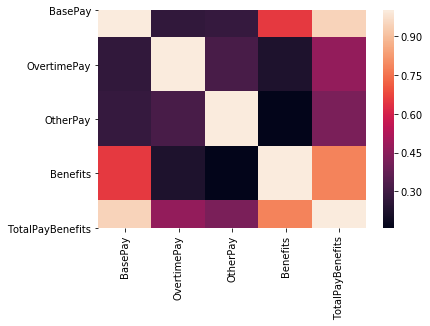

In [40]:
#Посмотрим, как данные коррелируют между собой
df_data=df2[['BasePay','OvertimePay','OtherPay','Benefits', 'TotalPayBenefits']]
df_data.head()
import seaborn as sns
sns.heatmap(df_data.corr())

In [41]:
df_data_corr=df_data.corr()
df_data_corr

,BasePay,OvertimePay,OtherPay,Benefits,TotalPayBenefits
BasePay,1.000000,0.269479,0.280745,0.654115,0.946767
OvertimePay,0.269479,1.000000,0.318307,0.226638,0.469517
OtherPay,0.280745,0.318307,1.000000,0.159542,0.421679
Benefits,0.654115,0.226638,0.159542,1.000000,0.781875
TotalPayBenefits,0.946767,0.469517,0.421679,0.781875,1.000000


In [ ]:
Следует отметить, что показатель 'BasePay' является влияющим, а показатели 
'Benefits','TotalPayBenefits' (достаточно высокий corr)   являются зависимыми.

In [ ]:
Посмотрим на распределение сотрудников с разным уровнем дохода.

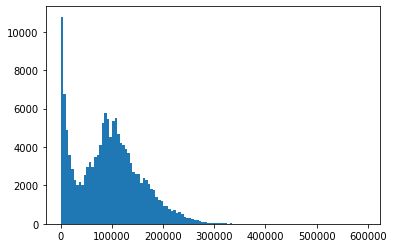

In [42]:
df2['TotalPayBenefits']
plt.hist(df2['TotalPayBenefits'],bins=list(range(0,600000,5000)));

In [43]:
df_fm=df2.groupby(['Year'])['TotalPayBenefits'].agg([np.median,np.mean, np.max])
df_fm

,median,mean,amax
Year,,,
2011,68219.910,71723.959868,567595.43
2012,101728.740,100466.191019,407274.78
2013,101944.325,101374.820615,425815.28
2014,101136.720,100257.243535,510732.68


In [ ]:

median и mean находятся достаточно близко, но окончательное решение об использовании в качестве меры
центральной тенденции в  данной задаче mean или median будет принято после оценки выбросов по данным.

In [ ]:
#Вызывают вопросы min значения данной выборки.max значения допускаем за счет зарплат высоких должностей в группах.

In [ ]:
Посмотрим на  max значения по уровню  базовых оплат 'BasePay' ****. Работаем с df2 размеченный


In [78]:
#Обозначим группы/год  одной переменной для удобства при дальнейшем использовании
all_group = ['office','police','medical','worker','services', 'operator','engineer',
     'public','fire','technicserv','attorney','transport','manager', 'finance','construction', 'trade']
year_sp=[2011,2012,2013,2014]

In [45]:
for  group in all_group:
    df_group = df2[df2['group1']==group]
    df_group=df_group[df_group['BasePay']==df_group['BasePay'].max()]
    print(df_group)

            Id    EmployeeName            JobTitle    BasePay  OvertimePay  \
110547  110548  Roland Pickens  Administrator, DPH  282619.96          0.0   

        OtherPay  Benefits   TotalPay  TotalPayBenefits  Year  \
110547       0.0  82941.18  282619.96         365561.14  2014   

       JobTitle_key_words_list  group1  
110547       administrator dph  office  
          Id    EmployeeName         JobTitle    BasePay  OvertimePay  \
72925  72926  Gregory P Suhr  Chief of Police  319275.01          0.0   

       OtherPay  Benefits   TotalPay  TotalPayBenefits  Year  \
72925  20007.06  86533.21  339282.07         425815.28  2013   

      JobTitle_key_words_list  group1  
72925         chief of police  police  
          Id   EmployeeName                  JobTitle   BasePay  OvertimePay  \
72953  72954  Susan  Currin  Adm, SFGH Medical Center  271831.5          0.0   

       OtherPay  Benefits  TotalPay  TotalPayBenefits  Year  \
72953    5000.0  75511.72  276831.5         352343

In [58]:
Проверка максимальных базовых оплат по группам показала, максимальные значения либо  у руководителей
подразделений, либо у специалистов групп с высокой оплатой. Находятся в рамках max значения зарплат в США******

In [ ]:
Точечно проверим max  значения 'OvertimePay', 'OtherPay', 'Benefits'

In [46]:
df2[df2['OvertimePay']==df2['OvertimePay'].max()]

,Id,EmployeeName,JobTitle,BasePay,OvertimePay,OtherPay,Benefits,TotalPay,TotalPayBenefits,Year,JobTitle_key_words_list,group1
1,2,GARY JIMENEZ,CAPTAIN III (POLICE DEPARTMENT),155966.02,245131.88,137811.38,0.0,538909.28,538909.28,2011,captain iii police department,police


In [50]:
df2[df2['JobTitle']=='CAPTAIN III (POLICE DEPARTMENT)'].head(2)
#выборка по должности CAPTAIN III (POLICE DEPARTMENT) показывает характерным  уровень базовых оплат. Здесь наблюдается
#аномально высокая плата за  переработку сотрудника, что оказывает влияние на общую з/п. Находится в рамках
#max значения зарплат в США******

,Id,EmployeeName,JobTitle,BasePay,OvertimePay,OtherPay,Benefits,TotalPay,TotalPayBenefits,Year,JobTitle_key_words_list,group1
1,2,GARY JIMENEZ,CAPTAIN III (POLICE DEPARTMENT),155966.02,245131.88,137811.38,0.0,538909.28,538909.28,2011,captain iii police department,police
2,3,ALBERT PARDINI,CAPTAIN III (POLICE DEPARTMENT),212739.13,106088.18,16452.60,0.0,335279.91,335279.91,2011,captain iii police department,police


In [55]:
df2[df2['OtherPay']==df2['OtherPay'].max()]#очень высокая позиция по должности.Допускаем такое max  значение.
# также наблюдается max значение суммарного дохода TotalPayBenefits, что также допускаем. 
#Находится в рамках max значения зарплат в США******

,Id,EmployeeName,JobTitle,BasePay,OvertimePay,OtherPay,Benefits,TotalPay,TotalPayBenefits,Year,JobTitle_key_words_list,group1
0,1,NATHANIEL FORD,GENERAL MANAGER-METROPOLITAN TRANSIT AUTHORITY,167411.18,0.0,400184.25,0.0,567595.43,567595.43,2011,general managermetropolitan transit authority,transport


In [56]:
df2[df2['Benefits']==df2['Benefits'].max()]#очень высокая позиция по должности.Допускаем такое max  значение.
#Находится в рамках max значения зарплат в США******

,Id,EmployeeName,JobTitle,BasePay,OvertimePay,OtherPay,Benefits,TotalPay,TotalPayBenefits,Year,JobTitle_key_words_list,group1
110533,110534,William J Coaker Jr.,Chief Investment Officer,257340.0,0.0,82313.7,96570.66,339653.7,436224.36,2014,chief investment officer,police


In [ ]:
Вывод. Сотрудники с  max  выплатами  Employee занимают высокие позиции JobTitle. 
Выше проведена горизонтальная арифметическая  проверка для исключения опечатки в данных.
Находится в рамках max значения зарплат в США******

In [ ]:
Вызывают вопрос минимальные значения зарплат. Похоже, что это подработки/доплаты и они искажают выборку.
Так, как выбока содержит сведения о  полноценных зарплатах за год.

In [138]:
df2_nul=df2[df2['TotalPayBenefits']<15080] #******min уровень зарплаты в США


In [52]:
df2_nul['group1'].unique()#Представлены все группы.

array(['attorney', 'worker', 'other', 'medical', 'services', 'manager',
       'finance', 'engineer', 'office', 'public', 'police', 'transport',
       'technicserv', 'trade', 'art', 'operator', 'employment', 'fire',
       'construction'], dtype=object)

In [53]:
df2_nul['Year'].unique()#Представлены все группы.

array([2011, 2012, 2013, 2014], dtype=int64)

In [54]:
len(df2_nul)/len(df2)*100

15.215276745788358

In [ ]:
Вывод: по min значениям-22,5 тыс работников (15% от общего объемов данных) имеют уровень заработной платы ниже min по США*****
Такие работники представлены во всех выделенных группах. Удалим этих работников из выборки и оставим работников
с полноценными зарплатами.

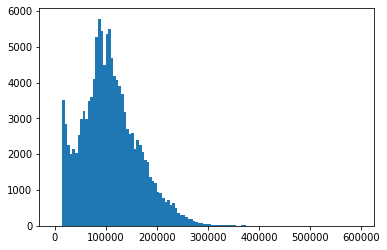

In [55]:
df2_basepay = df2.drop(df[df['TotalPayBenefits'] <15080].index)
df2_basepay
df2_basepay['TotalPayBenefits']
plt.hist(df2_basepay['TotalPayBenefits'],bins=list(range(0,600000,5000)));

In [137]:
df_fm=df2_basepay.groupby(['Year'])['TotalPayBenefits'].agg([np.median,np.mean, np.max])
df_fm

,median,mean,amax
Year,,,
2011,77477.820,84483.719275,567595.43
2012,110240.310,115706.300481,407274.78
2013,111395.555,118594.657041,425815.28
2014,111005.805,117562.319713,510732.68


In [ ]:
 median и mean расположены  относительно близко. Max значение зарплаты примерно в 4 раза выше   median и mean.
Принято решение в качестве меры центральной тенденции использовать median.

In [56]:
df_data=df_data1=df2_basepay[['BasePay','OvertimePay','OtherPay','Benefits', 'TotalPayBenefits']]

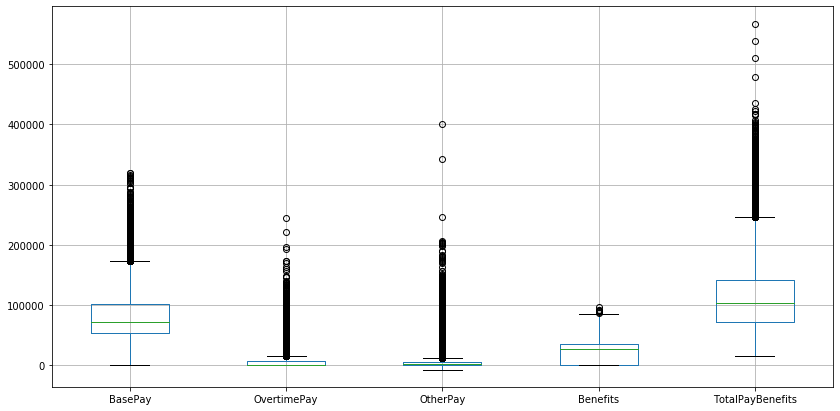

In [57]:
df_data.boxplot(figsize = (14, 7))

In [ ]:
Box plot

Центром является медиана значений. Верхняя граница -3 квартиль и Нижняя граница- 1 квартиль. Разность между 3 м и 1-м  квартилем
-межквартильный размах. Отложим 1,5 межквартильных размаха вверх от 3 квартиля и 1,5 межквартильных размахов вниз
от 1-го квартиля. Границы и будут конец усов квартиля.
По первому приближению наблюдается, что по всем  видам выплат есть некоторое количество  данных, лежащих выше границы Box plot


In [ ]:
Вывод:
-для дальнейшего анализа принято решение в качестве меры центральной тенденции выбрать median.Так как наблюдается
большой разрыв между max и mean/median зарплатами в группах. 

In [ ]:
IV. Статический анализ даных. Далее работаем с df2_st_an,с включением  представительных групп 

In [59]:

df2_st_an=df2_basepay[df2.group1.isin(all_group)]
df2_st_an.head(2)

C:\Users\HP\Anaconda3\lib\site-packages\ipykernel_launcher.py:1: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  """Entry point for launching an IPython kernel.


,Id,EmployeeName,JobTitle,BasePay,OvertimePay,OtherPay,Benefits,TotalPay,TotalPayBenefits,Year,JobTitle_key_words_list,group1
0,1,NATHANIEL FORD,GENERAL MANAGER-METROPOLITAN TRANSIT AUTHORITY,167411.18,0.00,400184.25,0.0,567595.43,567595.43,2011,general managermetropolitan transit authority,transport
1,2,GARY JIMENEZ,CAPTAIN III (POLICE DEPARTMENT),155966.02,245131.88,137811.38,0.0,538909.28,538909.28,2011,captain iii police department,police


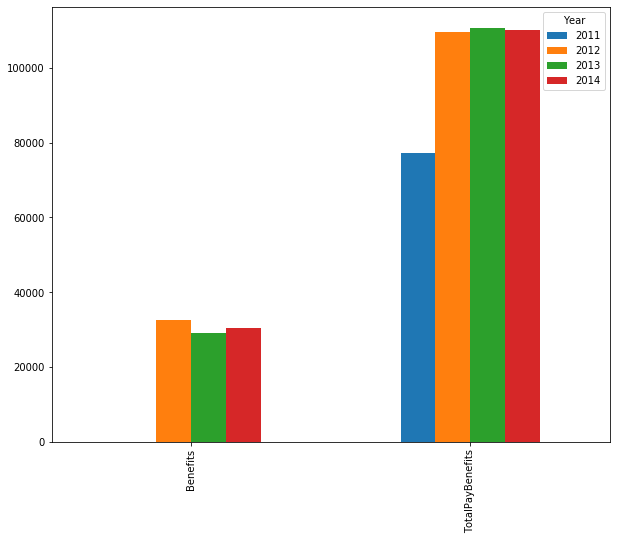

In [60]:
#Динамика зарплаты по годам
df_3=df2_st_an.groupby(['Year'])[ 'Benefits','TotalPayBenefits'].median().reset_index()
df_3.set_index('Year', inplace=True)
df_3=df_3.T
df_3.plot(kind='bar', figsize=(10, 8))


In [ ]:
Замечание:Наблюдается отсутствие 'Benefits' в 2011 году. Допущения:
-кризис США 2011 (вторая волна кризиса  2008 года). Также в 2011 году наблюдался самый высокий
уровень инфляции в США за 4 рассматриваемых в выборке  года****;
-данные пропущены.
Принято решение оставить так, как есть, так как при экстраполяции данных 'Benefits' с последующих лет на 2011 год не 
известен понижающий коэффициент за счет негативных макроэкономических событий 2011 года.
 
Самый высокий уровень зарплат в Сан- Франциско наблюдался в  2013 году.
Самый низкий - в 2011 году

In [73]:
df2_2011=df2[df2['Year']==2011]
df2_2011['Benefits'].sum()

0.0

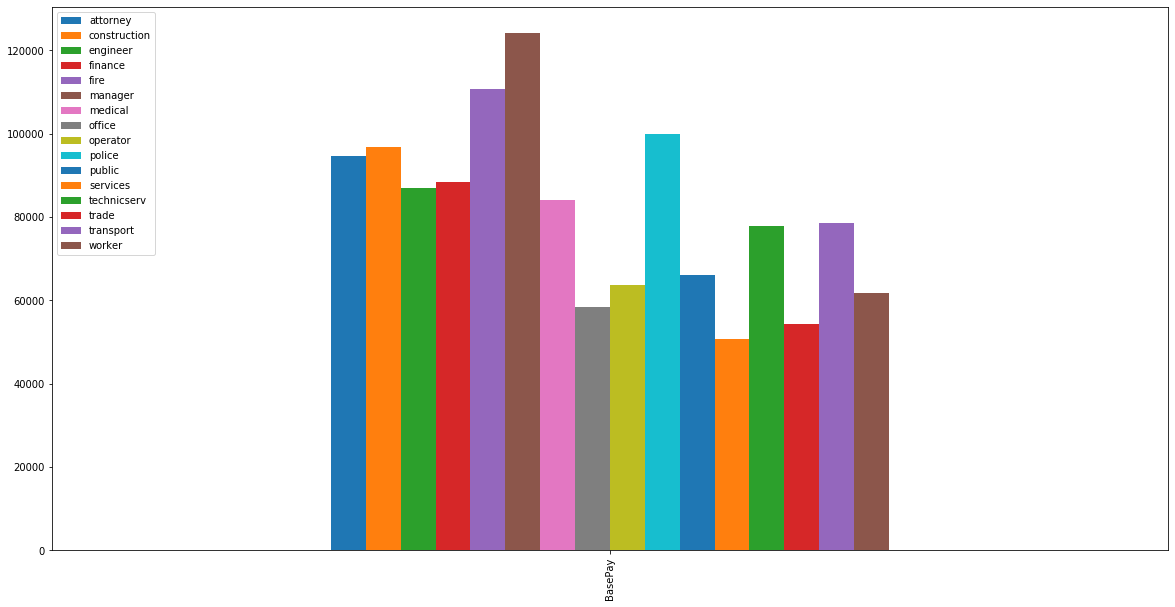

In [62]:
#Как распределяются базовая оплата, сверхурочная работа и льготы между разными группами? 

df_2=df2_st_an.groupby(['group1'])['BasePay'].median().reset_index()
df_2.set_index('group1', inplace=True)
df_2=df_2.T
df_2.plot(kind='bar', figsize=(20, 10))
plt.legend(loc='upper left')

In [ ]:
За период 2011-2014 гг.:
-max базовая оплата (median) на группу manager
-min базовая оплата (median) на группу servises

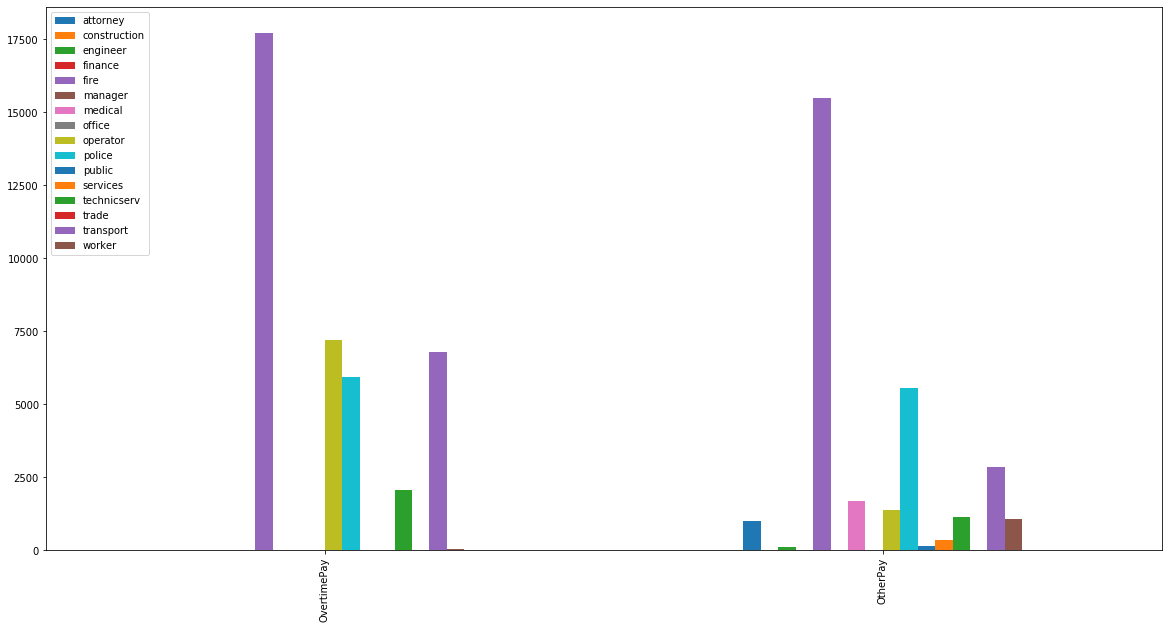

In [99]:
df_2=df2_st_an.groupby(['group1'])['OvertimePay', 'OtherPay'].median().reset_index()
df_2.set_index('group1', inplace=True)
df_2=df_2.T
df_2.plot(kind='bar', figsize=(20, 10))
plt.legend(loc='upper left')

In [ ]:
За период 2011-2014 гг.:

-max оплата за сверхурочную работу  на группу fire
-min оплата за сверхурочную работу  - группы с нулевыми значениями(ниже)

-max оплата льгот  на группу fire
-min оплата льгот   - группы с нулевыми значениями(ниже)


In [63]:
df2_st_an_o=df2_st_an.groupby(['group1'])['OvertimePay'].median().reset_index()
df2_st_an_o=df2_st_an_o.sort_values(by='OvertimePay', ascending=False)
df2_st_an_o

,group1,OvertimePay
4,fire,18175.870
8,operator,8736.585
14,transport,7482.255
9,police,6253.855
12,technicserv,3099.915
11,services,1131.905
13,trade,821.530
15,worker,180.680
6,medical,47.990
0,attorney,0.000


In [64]:
df2_st_an_ot=df2_st_an.groupby(['group1'])['OtherPay'].median().reset_index()
df2_st_an_ot=df2_st_an_ot.sort_values(by='OtherPay', ascending=False)
df2_st_an_ot

,group1,OtherPay
4,fire,15558.010
9,police,5777.510
6,medical,3032.000
14,transport,2976.660
8,operator,1585.670
12,technicserv,1480.000
15,worker,1194.730
0,attorney,1122.595
11,services,940.130
10,public,821.275


In [ ]:
V. Динамический анализ изменения данных по периоду.

In [ ]:
посмотрим на median, mean, amax в динамике.

In [69]:
df_fm=df2_st_an.groupby(['Year'])['TotalPayBenefits'].agg([np.median,np.mean, np.max])
df_fm

,median,mean,amax
Year,,,
2011,77362.205,84461.004727,567595.43
2012,109589.610,115175.382722,407274.78
2013,110758.740,118190.871875,425815.28
2014,110023.590,117118.709604,479652.21


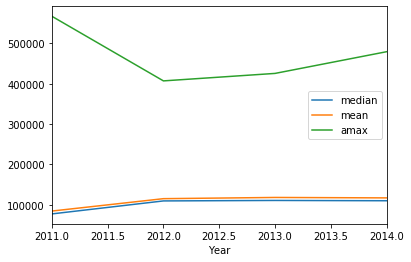

In [68]:
df_fm.plot()
plt.rcParams["figure.figsize"] = (10,8)

In [ ]:
Обратим внимание, что среднее и медианное значение расположены близко друг к другу, Это позволяет 
говорить о нормальном распределении  данных. 
За период 2011-2012 наблюдается снижение максимальных зарплат*****  и рост средних/медианных зарплат. 
За период 2013 -2014 год наблюдается рост максимальных зарплат  при  стабильном уровнем средних/медианных зарплат.
Наблюдается сильное отличие высоких зарплат от средних/медианных(примерно в 4 раза).

In [ ]:
Заработную плату в рамках данного исследования определяем, как 'TotalPayBenefits'****


In [70]:
df_4=df2_st_an.groupby(['Year', 'group1'])['TotalPayBenefits'].mean().reset_index()
df_4_1=df2_st_an.groupby(['Year', 'group1'])['TotalPayBenefits'].median().reset_index()
df_4_2=df2_st_an.groupby(['Year', 'group1'])['TotalPayBenefits'].max().reset_index()

In [ ]:
Как распределяется бюджет на разные группы (department) с течением времени

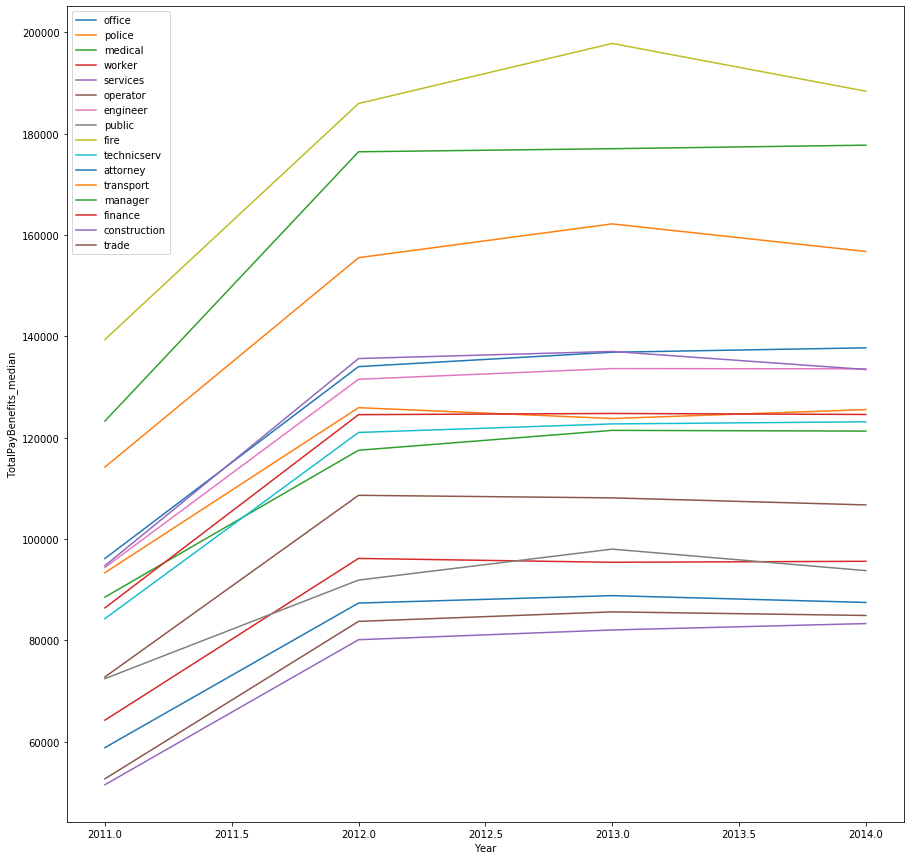

In [75]:
for  group in all_group:
    df_group = df_4_1[df_4_1['group1']==group]
    plt.plot(df_group['Year'], df_group['TotalPayBenefits'],label=group)#,kind='scatter')
    plt.legend() 

plt.xlabel('Year')  
plt.ylabel('TotalPayBenefits_median')
plt.rcParams["figure.figsize"] = (20,15)

In [ ]:
В период с 2011 по 2012 года наблюдается рост median зарплат по всем группам. В период с 2012 по 2013 год наблюдается
приемущественно стабилизация уровня зарплат в разрезе групп, за исключением групп:
-fire(пожарные)-рост;
-transport- незначительное снижение.

В период 2013-2014 год:
-снижение зарплаты по группе fire, police;
Изменения монотонны
max бюджет выделен на группу fire(пожарные службы)
min  бюджет выделен на группу services(сервисы)

In [ ]:
Максимальные значения по группам (департаментам) посмотрим на другом представлении в виде диаграмм.

In [89]:
data={}

for  group in all_group:
    df_group = df_4_2[df_4['group1']==group]
    data[group] = df_group['TotalPayBenefits'].values
data
    
    #plt.bar( df_group['Year'],df_group['TotalPayBenefits'])
    #df_group.plot.bar(x='Year',y='TotalPayBenefits')


{'office': array([316285.74, 360070.78, 362306.21, 365561.14]),
 'police': array([538909.28, 407274.78, 425815.28, 436224.36]),
 'medical': array([250122.04, 339368.15, 381697.8 , 374597.99]),
 'worker': array([168912.31, 219454.51, 213269.64, 226121.58]),
 'services': array([164425.  , 226380.12, 222342.91, 240735.06]),
 'operator': array([148711.28, 197206.13, 194195.79, 194246.76]),
 'engineer': array([179123.44, 240088.8 , 254521.86, 258022.86]),
 'public': array([198027.44, 376002.11, 401736.88, 479652.21]),
 'fire': array([326373.19, 386807.48, 422353.4 , 417435.1 ]),
 'technicserv': array([332343.61, 389496.02, 252675.52, 269001.26]),
 'attorney': array([234848.11, 301121.44, 313294.34, 314612.09]),
 'transport': array([567595.43, 359447.75, 270383.15, 252473.84]),
 'manager': array([230377.83, 312675.26, 303272.22, 316810.09]),
 'finance': array([135147.61, 224901.08, 192665.9 , 189951.2 ]),
 'construction': array([174226.4 , 214502.72, 241263.11, 249023.8 ]),
 'trade': array([

In [90]:

df_4['Year'].unique()

array([2011, 2012, 2013, 2014], dtype=int64)

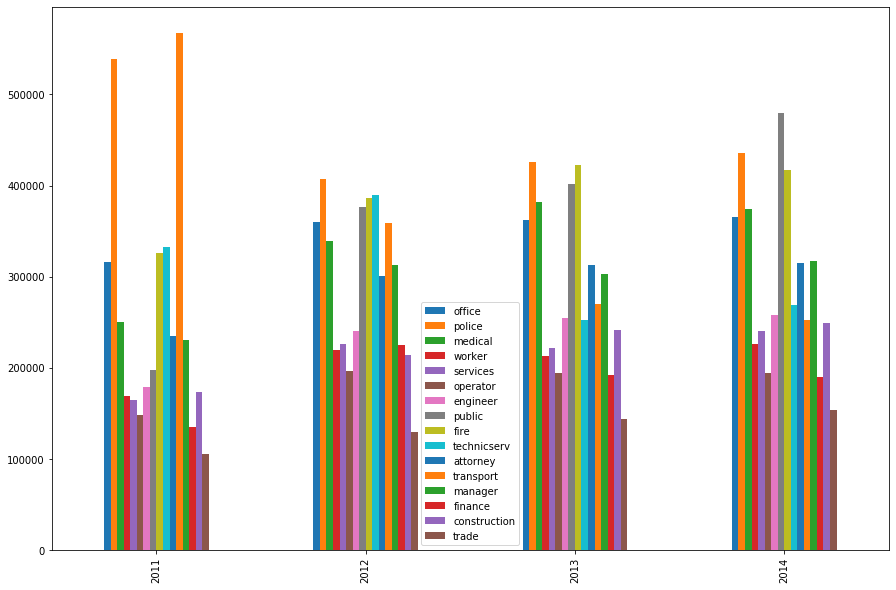

In [102]:

plotdata = pd.DataFrame(data, 
    index=df_4['Year'].unique())
    #index=np.array(year_sp)              
plotdata.plot(kind="bar", figsize=(15, 10))


In [ ]:
Наблюдается та же динамика, что и на графике в ячейке 68. Описание то же, но стоит отметить  изменение 
max зарплат по департаментам:
2011-police;
2012-transport;
2013--transport;
2014-public(гос служащие).
Следует отметить, что максимальные зарплаты чувствительны к изменениям .Уход/смена топ менеджера могла повлиять на изменение.

In [ ]:
Анализ состава зарплат 'TotalPay'  поиск аномалий.

In [105]:
df_5=df2_st_an.groupby(['Year', 'group1'])['BasePay','OvertimePay', 'OtherPay' ].median().reset_index()
df_5.head(5)

,Year,group1,BasePay,OvertimePay,OtherPay
0,2011,attorney,93837.080,0.000,0.000
1,2011,construction,94757.945,0.000,0.000
2,2011,engineer,82056.000,0.000,1377.455
3,2011,finance,86349.625,0.000,0.000
4,2011,fire,105934.660,16081.655,15356.055


In [107]:
Построим диаграммы по распределению со временем для каждого департамента по базовым, сверхурочным и льготам


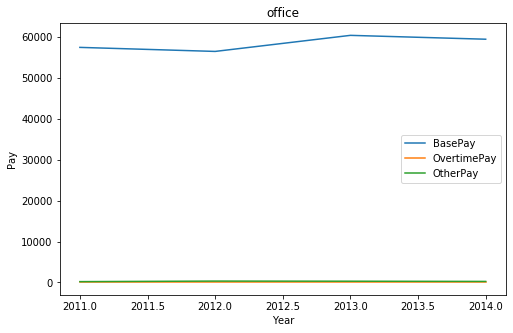

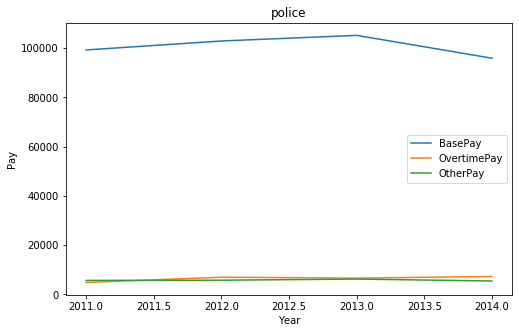

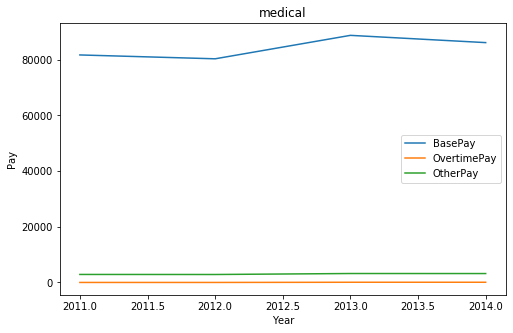

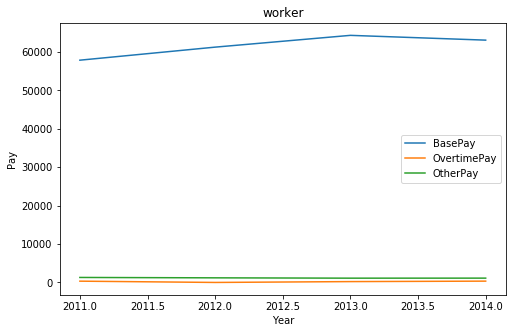

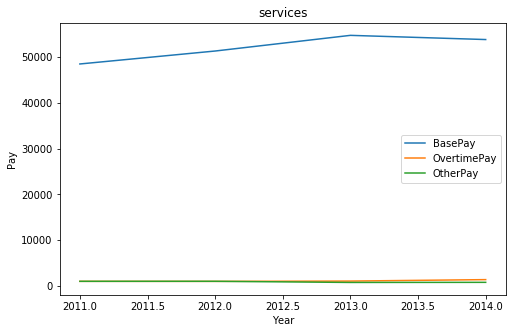

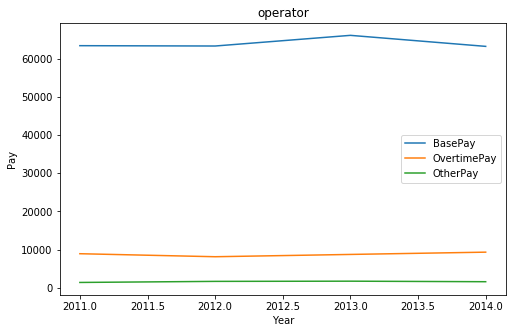

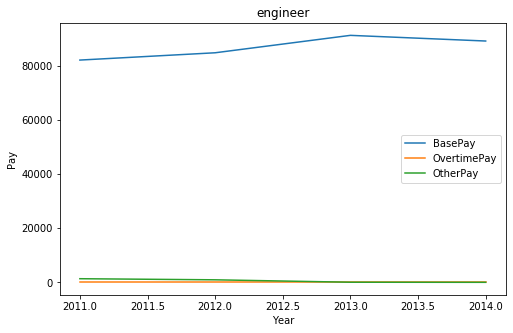

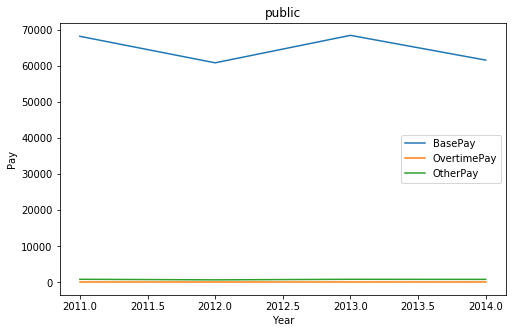

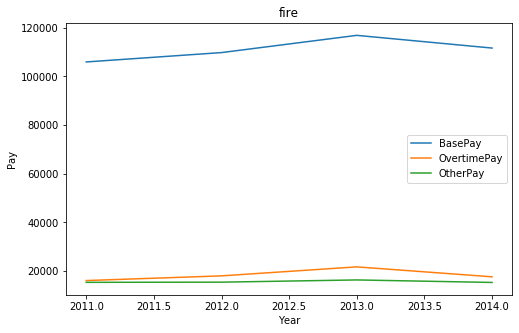

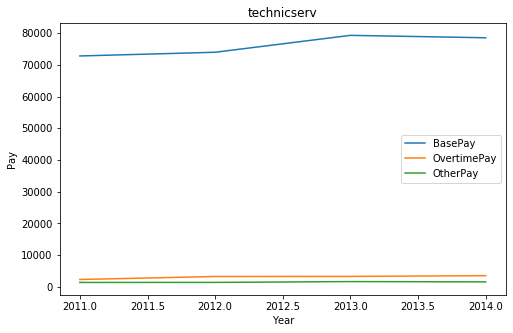

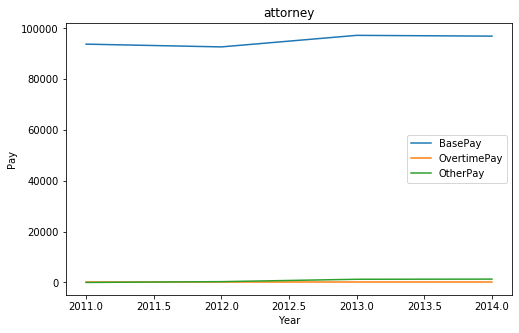

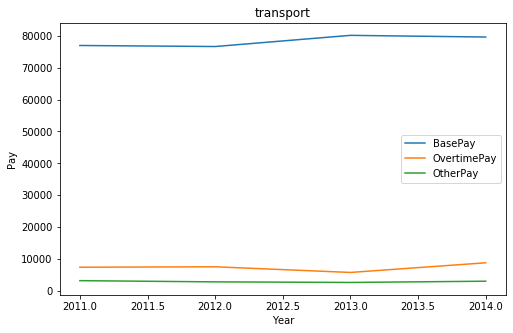

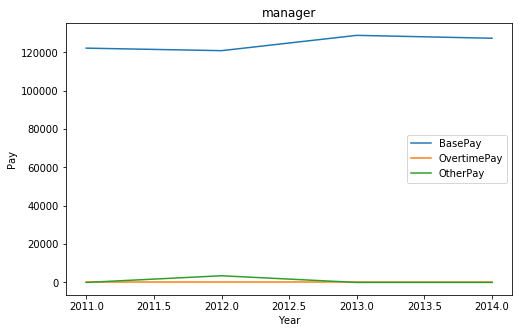

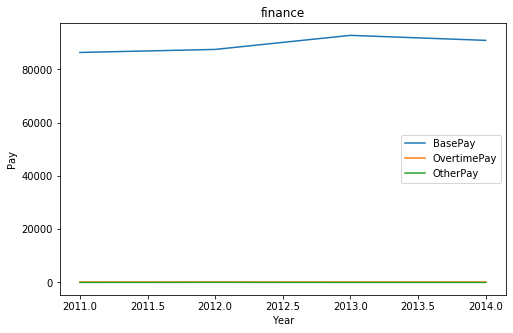

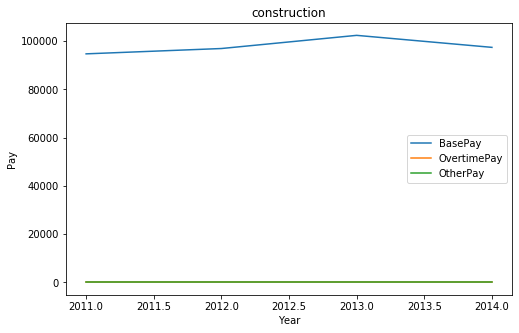

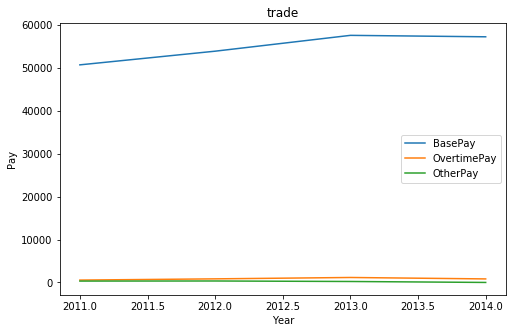

In [108]:
for  group in all_group:
    df_group = df_5[df_5['group1']==group]
    plt.plot(df_group['Year'], df_group['BasePay'],label='BasePay')
    plt.plot(df_group['Year'], df_group['OvertimePay'],label='OvertimePay')
    plt.plot(df_group['Year'], df_group['OtherPay'],label='OtherPay')
    #plt.plot(df_group['Year'], df_group['Benefits'],label='Benefits')
    plt.legend()
    plt.xlabel('Year')  
    plt.ylabel('Pay')
    plt.title(group)
    plt.show() 
       
    plt.rcParams["figure.figsize"] = (8,5)

In [ ]:
Вывод: по всем представленным группам основной составляющей зарплаты 'TotalPay' является базовая оплата 'BasePay'
(что подтверждено высоким corr).Уровень прочих выплат сверхурочным 'OvertimePay'и льготам 'OtherPay' низок.
Но выделяются группы transport, fire(пожарные), operator, по которым уровень 'OvertimePay' выше. Посмотрим далее

In [111]:
df_part=df2_st_an.copy()

In [112]:
df_part.head(2)

,Id,EmployeeName,JobTitle,BasePay,OvertimePay,OtherPay,Benefits,TotalPay,TotalPayBenefits,Year,JobTitle_key_words_list,group1
0,1,NATHANIEL FORD,GENERAL MANAGER-METROPOLITAN TRANSIT AUTHORITY,167411.18,0.00,400184.25,0.0,567595.43,567595.43,2011,general managermetropolitan transit authority,transport
1,2,GARY JIMENEZ,CAPTAIN III (POLICE DEPARTMENT),155966.02,245131.88,137811.38,0.0,538909.28,538909.28,2011,captain iii police department,police


In [114]:
df_part_groupe1=df_part.groupby(['group1'])['BasePay','OvertimePay','OtherPay','TotalPay'].sum()
df_part_groupe1
df_part_groupe1['BP/TP'] = df_part_groupe1['BasePay']/df_part_groupe1['TotalPay']*100
df_part_groupe1['OP/TP'] =df_part_groupe1['OvertimePay']/df_part_groupe1['TotalPay']*100
df_part_groupe1['Ot/TP'] = df_part_groupe1['OtherPay']/df_part_groupe1['TotalPay']*100
df_part_groupe1[['BP/TP','OP/TP','Ot/TP']].reset_index()

,group1,BP/TP,OP/TP,Ot/TP
0,attorney,95.901956,1.420347,2.677696
1,construction,98.044868,0.674647,1.280484
2,engineer,93.181169,2.799013,4.019818
3,finance,98.749556,0.219159,1.031285
4,fire,72.169098,17.538397,10.292505
5,manager,97.630240,0.038360,2.331400
6,medical,90.909349,2.774015,6.316636
7,office,95.260032,2.766970,1.972998
8,operator,79.531375,17.224938,3.243687
9,police,82.300128,9.944486,7.755387


In [ ]:
По  высокой доле оплаты за сверхурочную работу подразделений:
-fire (пожарное подразделение) 
-operator
-transport
-service
можно сделать интересные выводы:
- в Сан- Франциско много пожаров;
-средняя зарплата BasePay operator ниже среднего  уровня, но за счет работы сверхурочно уровень TotalPay
приближается к среднему уровню з/п. Возможная причина- способ увеличения дохода за счет сверхурочной работы по данной группе;
-оплата по группе transport ниже среднего уровня. Высокая доля сверхурочной работы возможно по причине 2, способ поднять доход
за счет переработки, а возможно это специфика процесса перевозок.


In [ ]:
статистики по median  по составляющим зарплат

In [116]:
df2_st_an_aa=df2_st_an.groupby(['group1'])['BasePay','OvertimePay', 'OtherPay','TotalPay'].median().reset_index()
df2_st_an_aa

,group1,BasePay,OvertimePay,OtherPay,TotalPay
0,attorney,94702.820,0.000,1122.595,100261.555
1,construction,96751.090,0.000,0.000,97333.025
2,engineer,86887.210,0.000,615.000,98085.450
3,finance,88453.840,0.000,0.000,88681.965
4,fire,110847.080,18175.870,15558.010,147161.750
5,manager,124256.320,0.000,0.000,126144.740
6,medical,84115.310,47.990,3032.000,91998.800
7,office,58414.700,0.000,250.000,60750.045
8,operator,63748.810,8736.585,1585.670,73753.635
9,police,99961.130,6253.855,5777.510,119304.100


In [117]:
df2_st_an_aa[df2_st_an_aa['BasePay']==df2_st_an_aa['BasePay'].max()]

,group1,BasePay,OvertimePay,OtherPay,TotalPay
5,manager,124256.32,0.0,0.0,126144.74


In [118]:
df2_st_an_aa[df2_st_an_aa['BasePay']==df2_st_an_aa['BasePay'].min()]

,group1,BasePay,OvertimePay,OtherPay,TotalPay
11,services,50686.6,1131.905,940.13,54909.13


In [119]:
df2_st_an_aa['BasePay'].mean()

81105.1503125

In [ ]:
При точечном рассмотрении  max  значений по оплате сверхурочной работы  'OvertimePay' (ячейка 50) было выявлено аномально
высокое значение. Рассмотрим,  является ли это тенденцией, или исключением. Выявим  позиции, по которым 
плата за переработку 'OvertimePay' выше, чем базовая оплата 'BasePay'

In [127]:
df2_st_an.head(1)

,Id,EmployeeName,JobTitle,BasePay,OvertimePay,OtherPay,Benefits,TotalPay,TotalPayBenefits,Year,JobTitle_key_words_list,group1,res
0,1,NATHANIEL FORD,GENERAL MANAGER-METROPOLITAN TRANSIT AUTHORITY,167411.18,0.0,400184.25,0.0,567595.43,567595.43,2011,general managermetropolitan transit authority,transport,167411.18


In [128]:
df2_st_an['res'] =df2_st_an['BasePay']-df2_st_an['OvertimePay']
df2_st_an.head(1)

C:\Users\HP\Anaconda3\lib\site-packages\ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


,Id,EmployeeName,JobTitle,BasePay,OvertimePay,OtherPay,Benefits,TotalPay,TotalPayBenefits,Year,JobTitle_key_words_list,group1,res
0,1,NATHANIEL FORD,GENERAL MANAGER-METROPOLITAN TRANSIT AUTHORITY,167411.18,0.0,400184.25,0.0,567595.43,567595.43,2011,general managermetropolitan transit authority,transport,167411.18


In [129]:
res=df2_st_an[df2_st_an['res']<0]
res.head(2)
res1=res.groupby(['group1'])['res',].sum().reset_index()
res1.sort_values(by='res', ascending=False)

,group1,res
0,attorney,-1584.85
6,services,-11650.20
4,operator,-52503.59
9,worker,-93525.51
7,technicserv,-163051.23
2,medical,-163067.49
3,office,-163100.65
1,fire,-464013.90
8,transport,-1062991.30
5,police,-1399069.48


In [130]:
res["group1"].value_counts()

transport      75
police         53
fire           31
medical        28
worker         27
office         17
technicserv    10
operator        9
attorney        2
services        1
Name: group1, dtype: int64

In [125]:
res[res['group1']=='transport'].head(2)

,Id,EmployeeName,JobTitle,BasePay,OvertimePay,OtherPay,Benefits,TotalPay,TotalPayBenefits,Year,JobTitle_key_words_list,group1,res
88,89,EVETTE GEER-STEVENS,TRANSIT SUPERVISOR,88062.0,135159.38,7018.60,0.0,230239.98,230239.98,2011,transit supervisor,transport,-47097.38
103,104,EDWARD DENNIS,TRANSIT SUPERVISOR,88400.7,126778.88,7228.67,0.0,222408.25,222408.25,2011,transit supervisor,transport,-38378.18


In [126]:
res[res['group1']=='police'].head(2)

,Id,EmployeeName,JobTitle,BasePay,OvertimePay,OtherPay,Benefits,TotalPay,TotalPayBenefits,Year,JobTitle_key_words_list,group1,res
1,2,GARY JIMENEZ,CAPTAIN III (POLICE DEPARTMENT),155966.02,245131.88,137811.38,0.0,538909.28,538909.28,2011,captain iii police department,police,-89165.86
154,155,WHITNEY YEE,DEPUTY SHERIFF,86840.00,112320.96,13544.56,0.0,212705.52,212705.52,2011,deputy sheriff,police,-25480.96


In [ ]:
Вывод:  Выявлена тенденция по разным группам. В основном transport, police- выделяется руководящий состав с высокими окладами.

In [ ]:
Рассмотрим аномально высокие значения по заработной плате среди групп. Присутствуют ли они в каждой группе? Какова  их  доля?
Для этого определимся с границей экстремально высоких значений по з/п.
Воспользуемся правилом 3 sigm. Допускаем, что экстремально
высокие значения находятся за пределами mean+3*std


In [132]:
for  group in all_group:
    print(group)
    #plt.vlines([mean_-3*sko_, mean_+3*sko_],0,400)
    df_board=df2_st_an[df2_st_an['group1']==group]['TotalPayBenefits']
    mean_=df_board.mean()
    sko_=df_board.std()
    print(round((df_board>mean_+3*sko_).sum()/len(df_board)*100,3))
  

office
0.677
police
0.18
medical
0.177
worker
0.568
services
0.517
operator
0.034
engineer
0.0
public
0.46
fire
0.572
technicserv
0.199
attorney
0.0
transport
0.387
manager
0.0
finance
0.031
construction
0.07
trade
0.184


In [ ]:
Вывод: В результате анализа данных по зарплате Сан- Франциско выявлены неблагоприятные факторы, влияющие на расходование
ФОТ. 

При базовой оплате 'BasePay' ниже среднего уровня по определенным группам наблюдается увеличение зарплаты сотрудников 'TotalPay' 
за счет оплаты сверхурочных часов 'OvertimePay'. 
Можно выделить группы:
-operator;
-services;
-technicserv;
-transport;
-trade.

У сотрудников пожарного подразделения(fire) базовая оплата 'BasePay' выше  среднего уровня, переработки возможны, видимо, из за
некой экстремальной ситуации на производстве -возможно, большого количества пожаров в Сан- Франциско.

Наблюдаются аномально высокие значения по оплате переработки  'OvertimePay' по подразделениям с уровнем базовой оплаты 'BasePay'
выше среднего. Следует выделить подразделение 'police' (сотрудники на руководящих должностях, сотрудники с высокими
окладами), подразделение  transport (сотрудники с высокими окладами).

Так же наблюдается большое отклонение медианной зарплаты сотрудников  и максимальных зарплат руководящего состава.Выявлены 
экстремально высокие значения по заработным платам по группам. Определены их доли в общей выборке по группам.
Здесь можно выделить группы:
-office-0.7% сотрудников;
-worker, fire-0.6% сотрудников;
-services,public-0.5 % сотрудников;
-transport- 0.4 % сотрудников.

На основании вышеизложенного,  для минимизации неблагоприятных факторов, влияющих на расход ФОТ Сан- Франциско
можно рассмотреть следующие мероприятия:
-сократить  переработку сотрудников, особенно на руководящих должностях, а также переработку сотрудников высокооплачиваемых 
подразделений, сотрудников с высокой базовой оплатой 'BasePay';
-рассмотреть вопрос о доле экстремально  высокооплачиваемых работников в группах там, где выявлены доли экстремально
высоких зарплат, особенно в группах с размером зарплат ниже среднего уровня;
-по пожарному департаменту(fire) рассмотреть вопрос об увеличении/изменении  штата, проанализировав статистику по пожарам 
Сан- Франциско.




In [ ]:
Линейная регрессия

In [133]:
#Базовый df
df2_st_an.head()

,Id,EmployeeName,JobTitle,BasePay,OvertimePay,OtherPay,Benefits,TotalPay,TotalPayBenefits,Year,JobTitle_key_words_list,group1,res
0,1,NATHANIEL FORD,GENERAL MANAGER-METROPOLITAN TRANSIT AUTHORITY,167411.18,0.00,400184.25,0.0,567595.43,567595.43,2011,general managermetropolitan transit authority,transport,167411.18
1,2,GARY JIMENEZ,CAPTAIN III (POLICE DEPARTMENT),155966.02,245131.88,137811.38,0.0,538909.28,538909.28,2011,captain iii police department,police,-89165.86
2,3,ALBERT PARDINI,CAPTAIN III (POLICE DEPARTMENT),212739.13,106088.18,16452.60,0.0,335279.91,335279.91,2011,captain iii police department,police,106650.95
3,4,CHRISTOPHER CHONG,WIRE ROPE CABLE MAINTENANCE MECHANIC,77916.00,56120.71,198306.90,0.0,332343.61,332343.61,2011,wire rope cable maintenance mechanic,technicserv,21795.29
4,5,PATRICK GARDNER,"DEPUTY CHIEF OF DEPARTMENT,(FIRE DEPARTMENT)",134401.60,9737.00,182234.59,0.0,326373.19,326373.19,2011,deputy chief of departmentfire department,fire,124664.60


In [134]:
def prepare_data(df,name_group):
    df_group=df[df['group1']==name_group]
    features = df_group['Year'].to_numpy().reshape(-1, 1)
    target = df_group['TotalPayBenefits'].to_numpy()
    X_train,X_test,y_train, y_test = train_test_split(features,target, test_size=0.3, random_state=0)
        
    return (X_train,X_test,y_train, y_test)

In [135]:
def learning_model(X_train,X_test,y_train, y_test):
    model = LinearRegression()
    model.fit(X_train, y_train)
    y_train_prediction = model.predict(X_train)
    y_test_prediction = model.predict(X_test)
    print("RMSE тестовой выборки LinearRegression: ",np.sqrt(mean_squared_error(y_test, y_test_prediction)))
    return model,y_train_prediction,y_test_prediction

In [158]:
#gr=df2_st_an['group1'].unique()
#gr

array(['transport', 'police', 'technicserv', 'fire', 'office', 'medical',
       'attorney', 'manager', 'public', 'engineer', 'construction',
       'worker', 'services', 'operator', 'finance', 'trade'], dtype=object)

office
RMSE тестовой выборки LinearRegression:  34078.29214722114
рост зп 6667.1
предсказание ср зп на 2015 год 96262.1
средние зп на 2011-2014 год [69593.6 76260.7 82927.9 89595. ]


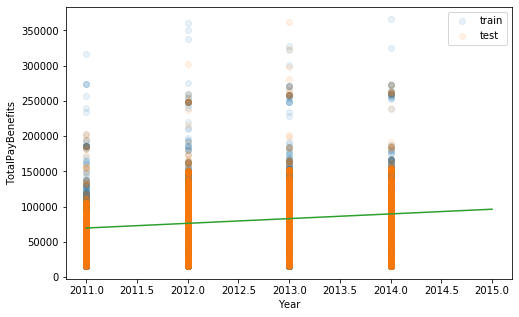

police
RMSE тестовой выборки LinearRegression:  52851.87993894708
рост зп 12299.8
предсказание ср зп на 2015 год 172668.8
средние зп на 2011-2014 год [123469.6 135769.4 148069.2 160369. ]


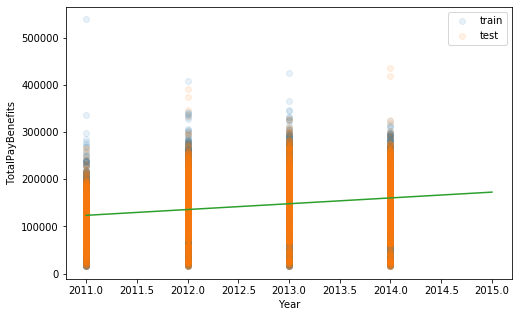

medical
RMSE тестовой выборки LinearRegression:  61965.40892495559
рост зп 9937.5
предсказание ср зп на 2015 год 137723.7
средние зп на 2011-2014 год [ 97973.5 107911.1 117848.6 127786.2]


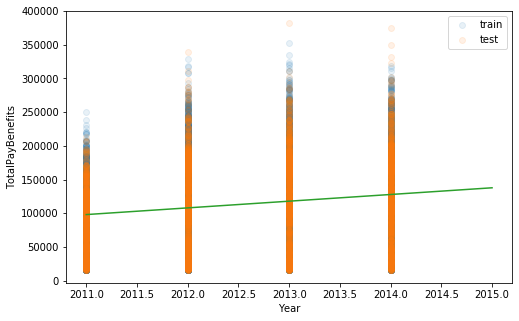

worker
RMSE тестовой выборки LinearRegression:  31184.75205643075
рост зп 9390.9
предсказание ср зп на 2015 год 110353.1
средние зп на 2011-2014 год [ 72789.5  82180.4  91571.3 100962.2]


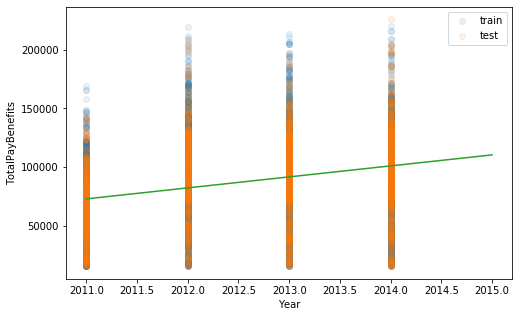

services
RMSE тестовой выборки LinearRegression:  26659.241607244898
рост зп 8301.2
предсказание ср зп на 2015 год 88540.6
средние зп на 2011-2014 год [55335.8 63637.  71938.2 80239.4]


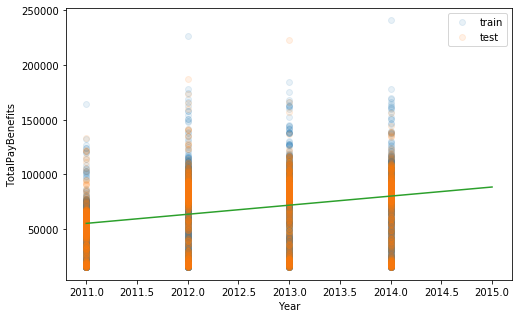

operator
RMSE тестовой выборки LinearRegression:  31557.805258430297
рост зп 8139.7
предсказание ср зп на 2015 год 112511.9
средние зп на 2011-2014 год [ 79953.1  88092.8  96232.5 104372.2]


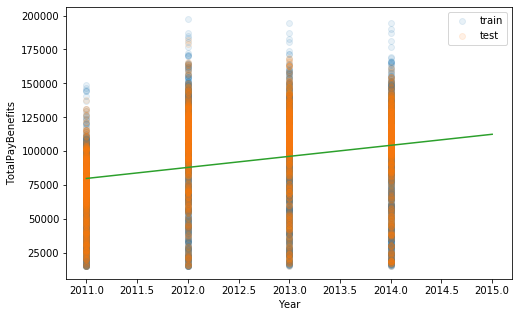

engineer
RMSE тестовой выборки LinearRegression:  45343.88816232034
рост зп 11179.6
предсказание ср зп на 2015 год 147903.9
средние зп на 2011-2014 год [103185.4 114365.  125544.7 136724.3]


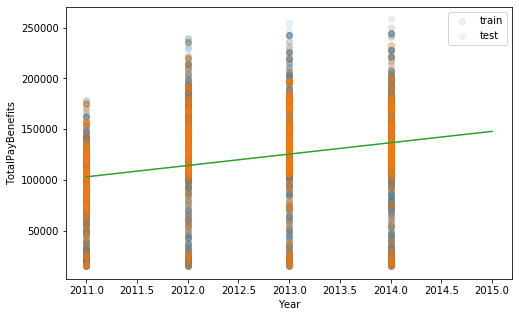

public
RMSE тестовой выборки LinearRegression:  50884.26798876992
рост зп 7745.1
предсказание ср зп на 2015 год 102457.1
средние зп на 2011-2014 год [71476.9 79221.9 86967.  94712.1]


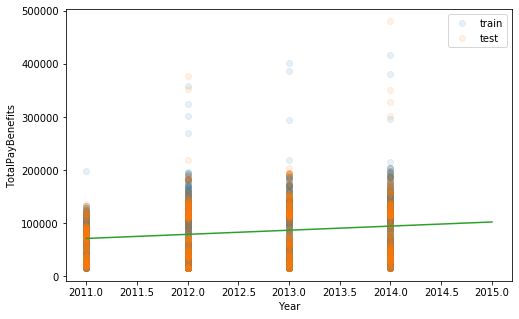

fire
RMSE тестовой выборки LinearRegression:  54667.94745218355
рост зп 13058.7
предсказание ср зп на 2015 год 206479.7
средние зп на 2011-2014 год [154244.9 167303.6 180362.3 193421. ]


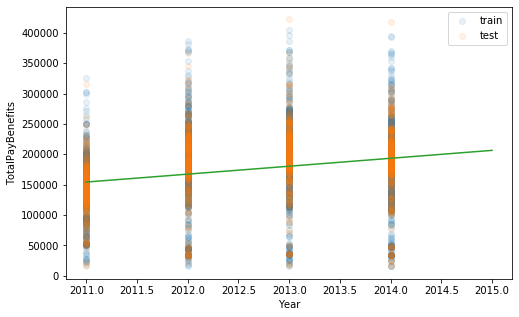

technicserv
RMSE тестовой выборки LinearRegression:  44391.141794928895
рост зп 10588.2
предсказание ср зп на 2015 год 138082.8
средние зп на 2011-2014 год [ 95730.2 106318.3 116906.5 127494.6]


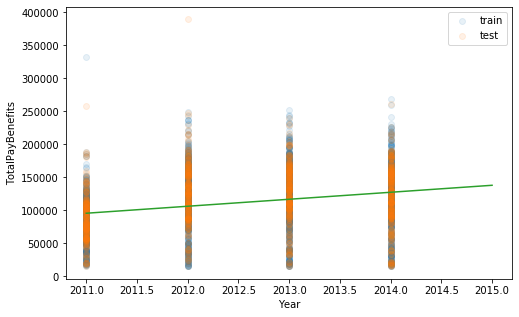

attorney
RMSE тестовой выборки LinearRegression:  61676.40302020082
рост зп 15394.0
предсказание ср зп на 2015 год 171571.2
средние зп на 2011-2014 год [109995.1 125389.1 140783.2 156177.2]


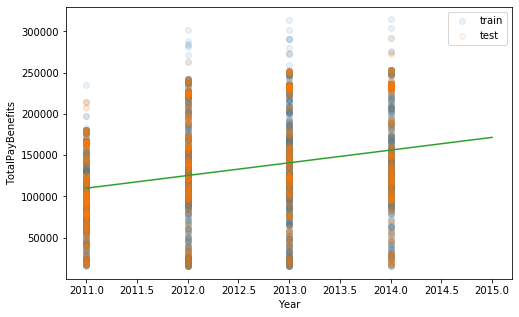

transport
RMSE тестовой выборки LinearRegression:  40981.29391377931
рост зп 8062.0
предсказание ср зп на 2015 год 138141.9
средние зп на 2011-2014 год [105894.  113956.  122017.9 130079.9]


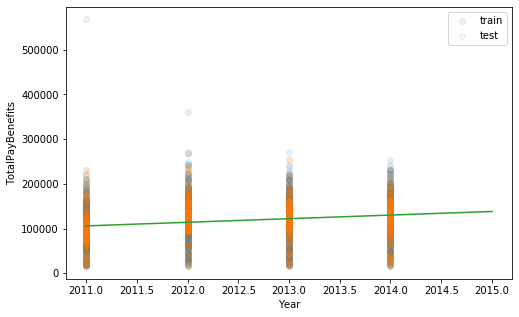

manager
RMSE тестовой выборки LinearRegression:  49761.934461858975
рост зп 15757.3
предсказание ср зп на 2015 год 196876.1
средние зп на 2011-2014 год [133846.8 149604.1 165361.4 181118.8]


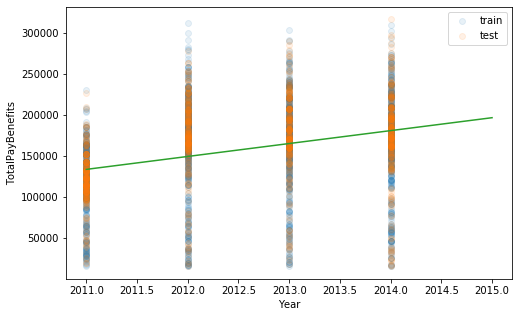

finance
RMSE тестовой выборки LinearRegression:  36723.28707938369
рост зп 9973.3
предсказание ср зп на 2015 год 134252.3
средние зп на 2011-2014 год [ 94359.1 104332.4 114305.7 124279. ]


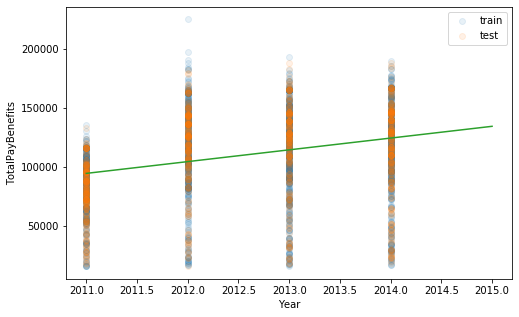

construction
RMSE тестовой выборки LinearRegression:  40212.14999514931
рост зп 10929.8
предсказание ср зп на 2015 год 147037.3
средние зп на 2011-2014 год [103318.1 114247.9 125177.7 136107.5]


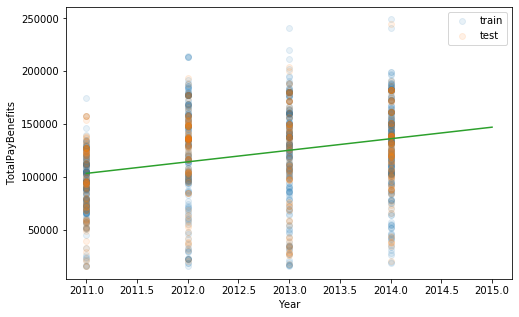

trade
RMSE тестовой выборки LinearRegression:  25554.204143964984
рост зп 8942.8
предсказание ср зп на 2015 год 95153.4
средние зп на 2011-2014 год [59382.4 68325.2 77267.9 86210.7]


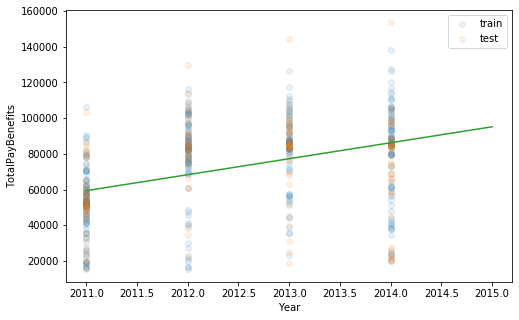

In [136]:
for obj in all_group:
    print(obj)
    X_train,X_test,y_train, y_test=prepare_data(df2_st_an, obj)
    model,y_train_prediction,y_test_prediction=learning_model(X_train,X_test,y_train, y_test)
    print('рост зп', (model.coef_[0]).round(1))

    X_plot=np.array([2011,2012,2013,2014,2015]).reshape(-1, 1)
    y_plot = model.predict(X_plot)
    print('предсказание ср зп на 2015 год', (y_plot[-1]).round(1))
    print('средние зп на 2011-2014 год', (y_plot[0:4:1]).round(1))
    
    plt.figure()
    plt.plot(X_train, y_train,'o',alpha=0.1)
    plt.plot(X_test, y_test,'o',alpha=0.1)
    plt.plot(X_plot, y_plot)
    plt.xlabel('Year')
    plt.ylabel('TotalPayBenefits')
    plt.legend(['train', 'test'])
    plt.show()
     

In [ ]:
Дополнительно был рассчитан 'угол роста' по целевому taget (model.coef)
по max рост з/п - у группы manager
по min рост з/п - у группы office


In [ ]:
Справочно:

In [185]:
df = pd.read_csv('Salaries1.csv',  sep=',')
df.head(2)

C:\Users\HP\Anaconda3\lib\site-packages\IPython\core\interactiveshell.py:3058: DtypeWarning: Columns (3,4,5,6,12) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


,Id,EmployeeName,JobTitle,BasePay,OvertimePay,OtherPay,Benefits,TotalPay,TotalPayBenefits,Year,Notes,Agency,Status
0,1,NATHANIEL FORD,GENERAL MANAGER-METROPOLITAN TRANSIT AUTHORITY,167411,0,400184,NaN,567595.43,567595.43,2011,NaN,San Francisco,NaN
1,2,GARY JIMENEZ,CAPTAIN III (POLICE DEPARTMENT),155966,245132,137811,NaN,538909.28,538909.28,2011,NaN,San Francisco,NaN


In [ ]:
*Анализ уникальных значений df

In [20]:
print('Монотонность - ',df.Id.is_monotonic)

Монотонность -  True


In [26]:
df["EmployeeName"].unique()

array(['NATHANIEL FORD', 'GARY JIMENEZ', 'ALBERT PARDINI', ...,
       'Charlene D Mccully', 'Not provided', 'Joe Lopez'], dtype=object)

In [28]:
df["JobTitle"].unique()

array(['GENERAL MANAGER-METROPOLITAN TRANSIT AUTHORITY',
       'CAPTAIN III (POLICE DEPARTMENT)',
       'WIRE ROPE CABLE MAINTENANCE MECHANIC', ..., 'Conversion',
       'Cashier 3', 'Not provided'], dtype=object)

In [21]:
df["Year"].unique()

array([2011, 2012, 2013, 2014], dtype=int64)

In [22]:
df["Agency"].unique()

array(['San Francisco'], dtype=object)

In [23]:
df["Status"].unique()

array([nan, 'PT', 'FT'], dtype=object)

In [ ]:
** % NaN по колонке df'Status'

In [42]:
df['Status'].isnull().sum()/len(df['Status'])*100

74.35723223054879

In [ ]:
*** Анализ дубликатов

In [20]:
#Определим  дубликаты  по нескольким признакамиз df.
df[df[["EmployeeName", "JobTitle",'Year']].duplicated()]


,Id,EmployeeName,JobTitle,BasePay,OvertimePay,OtherPay,Benefits,TotalPay,TotalPayBenefits,Year
3689,3690,STANLEY LEE,POLICE OFFICER III,112405.47,7589.08,14006.52,NaN,134001.07,134001.07,2011
3763,3764,MATTHEW SULLIVAN,POLICE OFFICER II,95636.67,8882.45,28831.58,NaN,133350.70,133350.70,2011
4821,4822,CHRISTOPHER ANDERSON,POLICE OFFICER III,112441.78,7224.09,5703.71,NaN,125369.58,125369.58,2011
5250,5251,RYAN JONES,POLICE OFFICER I,99964.19,8528.02,14471.11,NaN,122963.32,122963.32,2011
7326,7327,MICHAEL TSANG,ENGINEER,111613.03,0.00,0.00,NaN,111613.03,111613.03,2011
...,...,...,...,...,...,...,...,...,...,...
148266,148267,Hilda Erlenbach,Special Nurse,352.52,0.00,0.00,80.38,352.52,432.90,2014
148324,148325,Kristen E Sligar,Nurse Practitioner,291.65,0.00,0.00,67.99,291.65,359.64,2014
148366,148367,Maribel Amodo,Special Nurse,247.16,0.00,0.00,52.67,247.16,299.83,2014
148405,148406,Amelie E Bullard,Special Nurse,217.93,0.00,0.00,31.16,217.93,249.09,2014


In [24]:
df[df["EmployeeName"]=='MATTHEW SULLIVAN']

,Id,EmployeeName,JobTitle,BasePay,OvertimePay,OtherPay,Benefits,TotalPay,TotalPayBenefits,Year
2175,2176,MATTHEW SULLIVAN,POLICE OFFICER II,107797.61,16220.74,26736.29,NaN,150754.64,150754.64,2011
3763,3764,MATTHEW SULLIVAN,POLICE OFFICER II,95636.67,8882.45,28831.58,NaN,133350.70,133350.70,2011


In [ ]:
df.drop_duplicates(subset=["EmployeeName", "JobTitle",'Year'], keep='last')

In [ ]:
****Определение заработной платы
Заработная плата (оплата труда работника) - вознаграждение за труд , а также компенсационные выплаты 
(доплаты и надбавки компенсационного характера) и стимулирующие выплаты (доплаты и надбавки стимулирующего характера, 
премии и иные поощрительные выплаты).
Определяем 'TotalPayBenefits'

In [ ]:
*****Уровень инфляции в США:
2011 -2.96%
2012-1.74%
2013-1.5%
2014-0.76%
2015-0.76%

In [ ]:
******Уровень зарплат в США по данным открытых источников:
-min уровень зарплат в США по состоянию на декабрь 2015 года составлял  15080 долл США в год;
-max уровень зарплат в США составляе  504000 долл США в год (с учетом бонусов) +- годовые бонусы.

In [66]:
df_2=df2_st_an.groupby(['group1'])['BasePay','OvertimePay', 'OtherPay','TotalPay'].mean().reset_index()
df_2

,group1,BasePay,OvertimePay,OtherPay,TotalPay
0,attorney,102180.157288,1513.329802,2852.991269,106546.478359
1,construction,92859.056944,638.963725,1212.756718,94710.777387
2,engineer,89624.262663,2692.168829,3866.373946,96182.805438
3,finance,84149.412230,186.756286,878.809610,85214.978126
4,fire,105824.452801,25717.256801,15092.314379,146634.023981
5,manager,121612.804215,47.782878,2904.100993,124564.688086
6,medical,84500.475622,2578.453945,5871.329769,92950.259336
7,office,58242.134836,1691.729543,1206.294265,61140.158644
8,operator,55823.244081,12090.221357,2276.750752,70190.216190
9,police,96575.507076,11669.407528,9100.598190,117345.512794


In [ ]:
#Выделение долей

In [ ]:
#df_part['BP/TP'] = df_part['BasePay']/df_part['TotalPay']*100
#df_part['OP/TP'] = df_part['OvertimePay']/df_part['TotalPay']*100
#df_part['Ot/TP'] = df_part['OtherPay']/df_part['TotalPay']*100